# Reciprocity and sensitivity kernels for sea level fingerprints

This notebook illustrates the reciprocity relations discussed in the paper by Al-Attar *et al.* (2023)
 of the same name which is soon to be submitted. In particular, this notebook includes code used to generate 
 all the figures included within that paper. Note that all quantities within the calculations have SI units, but the form of these units is not always shown.

## Setting up the codes

First, we load in the necesarry Python modules. The module ```SLmod.py``` contains much of the code needed for the calculations.

In [1]:
%load_ext autoreload
%autoreload 2

# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pyshtools as pysh
import SLmod as SL
from numpy import pi as pi

#set plotting parameters
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [16, 8]

# get values for some physical parameters
b = SL.b
g = SL.g
rhoi = SL.rhoi
rhow = SL.rhow

Now we read in the present day distribution of sea level and ice. This is taken from the ice6g model of:

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014JB011176

The values of the fields are interpolated onto a Gauss Legendre grid at the chosen expansion order. Note that for the calculations in this notebook L = 256 or higher is a sensible value. The maximum possible is L = 1024, this being set by the Love numbers that have been pre-calculated and are read in below. The code also works out the ocean function from sea level and ice thickness. Note that the defintion of the ocean function calculation does not account for isolated regions below sea level. As a result, the Caspian sea is regarded as part of the oceans. This could be readily fixed, but the effects are small and are not important for our present purposes.

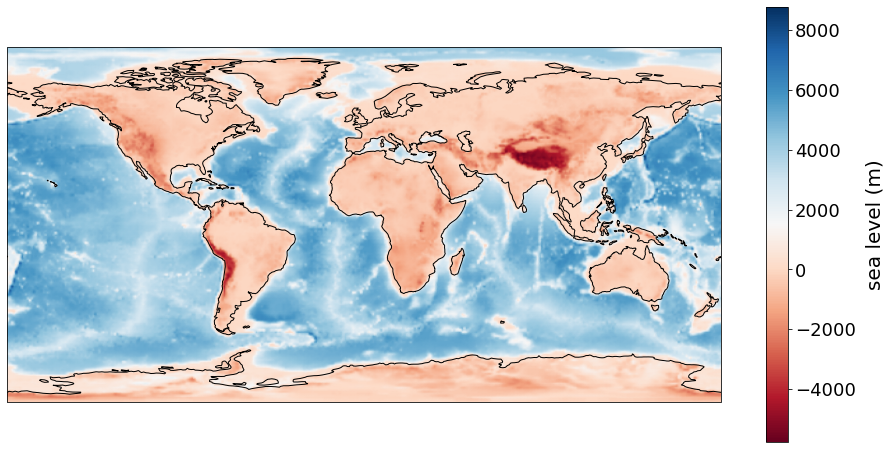

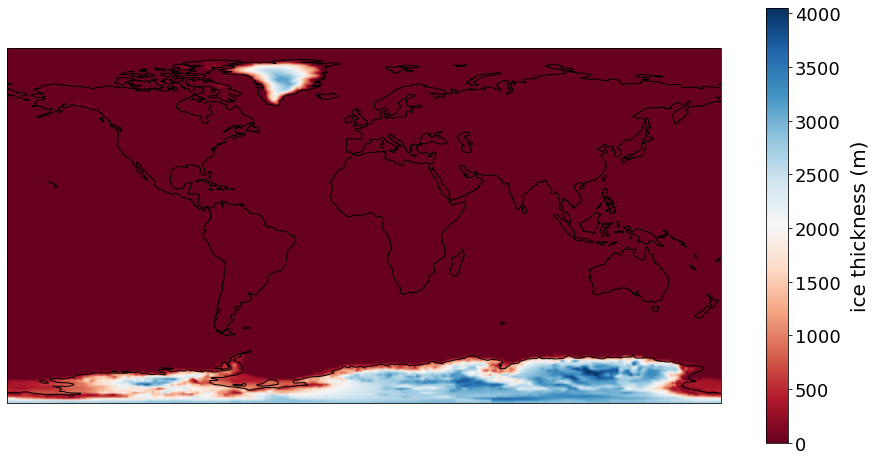

fraction of surface which is ocean =  0.712960233719624


In [2]:
# set the truncation degree
L=256

# read in the present day sea level and ice thickness
sl0,ice0 = SL.get_sl_ice_data(L)

# plot these fields
SL.plot(sl0,label = 'sea level (m)')
SL.plot(ice0,label = 'ice thickness (m)')

# compute the ocean function
C = SL.ocean_function(sl0,ice0)

# work out the ocean area and check the value
A = SL.surface_integral(C)
A_earth = 4*pi*b**2
print('fraction of surface which is ocean = ',A/A_earth)

## Solving the sea level equation to make a synthetic data set


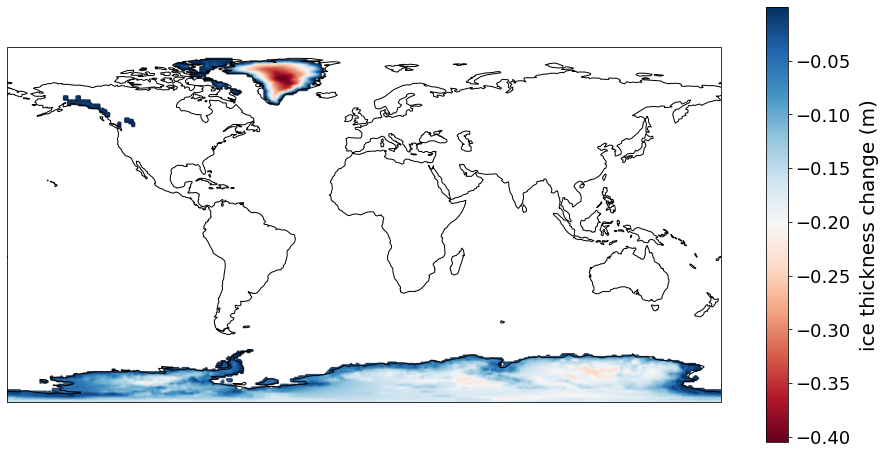

iteration =  1 relative change =  0.04661268007606478
iteration =  2 relative change =  0.005983326706320028
iteration =  3 relative change =  0.0010635781073450208
iteration =  4 relative change =  0.0002135820340964832
iteration =  5 relative change =  4.6780192459789834e-05
iteration =  6 relative change =  1.1012848851666909e-05
iteration =  7 relative change =  2.7651920011401216e-06
iteration =  8 relative change =  7.35820866553256e-07
iteration =  9 relative change =  2.0595849898608476e-07
iteration =  10 relative change =  6.008272617327457e-08
iteration =  11 relative change =  1.8085698754547217e-08
iteration =  12 relative change =  5.5716215885766386e-09


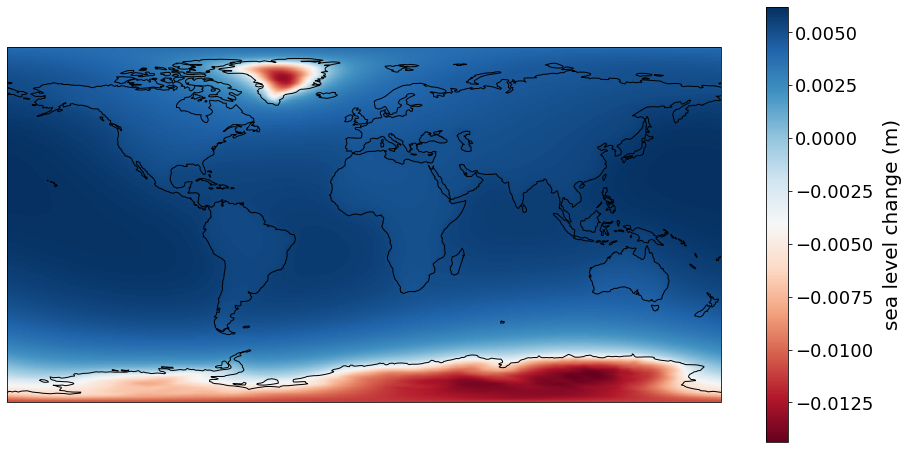

In [3]:
# set to true to use a random ice change model
use_random = False

if(use_random):
    Q = SL.sobolev_covariance(L,s = 2,mu = 0.2)
    zeta_north = -rhoi*SL.greenland_mask(sl0,ice0,val = 0.)*SL.random_field(Q)
    zeta_south = -rhoi*SL.antarctica_mask(sl0,ice0,val = 0.)*SL.random_field(Q)
else:
    zeta_north = -rhoi*SL.zero_southern_hemisphere(ice0)
    zeta_south = -rhoi*SL.zero_northern_hemisphere(ice0)
        
    
# normalise by GMSL contributions
GMSL_north = SL.bathtub(C,zeta_north)
GMSL_south = SL.bathtub(C,zeta_south)
zeta_north /= GMSL_north
zeta_south /= GMSL_south

# set the rate of GMSL change in mm
GMSL = 0.005

# set the northern and southern fractions
f_north = 0.2
f_south = 1.-f_north

# set the combined ice load
zeta = GMSL*(f_north*zeta_north + f_south*zeta_south)

# plot the result with suitable mask
ice_mask = SL.ice_mask(sl0,ice0)
SL.plot(ice_mask*zeta/SL.rhoi,label = r'ice thickness change (m)')

# solve the fingerprint problem
sl,u,phi,om,psi = SL.fingerprint(C,zeta)
ocean_mask = SL.ocean_mask(sl0,ice0)

# plot the result globally
SL.plot(sl,label = r'sea level change (m)')



## Sensitivity kernel for sea level at a given location


iteration =  1 relative change =  0.007498800294154418
iteration =  2 relative change =  0.00028322888822820134
iteration =  3 relative change =  3.5833581908738264e-05
iteration =  4 relative change =  7.0167958563502436e-06
iteration =  5 relative change =  1.5299507135951093e-06
iteration =  6 relative change =  3.593374118360069e-07
iteration =  7 relative change =  9.045170875441309e-08
iteration =  8 relative change =  2.427644318548086e-08
iteration =  9 relative change =  6.950019017976154e-09


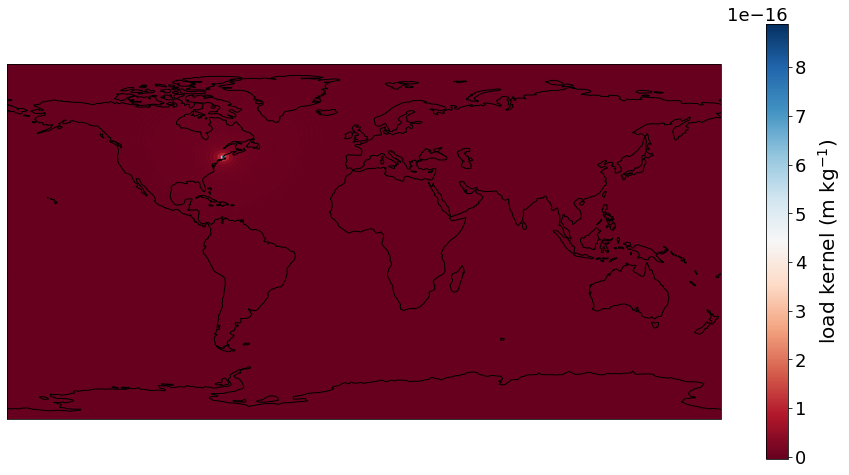

direct sea level value =  0.004619234474187692
left hand side         =  0.004619234474187696
right hand side        =  0.004619235234090143
relative difference    =  1.6450830795382698e-07


In [4]:
# set the observation point to Boston
lat =  42.3601
lon = -71.0589

# compute the adjoint load
zeta_d,_,_,_ = SL.sea_level_load(L,lat,lon,angle = 0.)

# solve the sea level equation for SL^{\dagger} and plot
sl_d,_,_,_,_ = SL.fingerprint(C,zeta_d)
SL.plot(sl_d,label = r'load kernel (m kg$^{-1}$)')


# set the value of sea level directly from the field 
sl_direct = SL.point_evaluation(sl,lat,lon)

# evaluate the sea level by integration against the delta load
lhs = SL.surface_integral(zeta_d*sl)

# now get the value by integrating the sensitivity kernel against the direct load
rhs = SL.surface_integral(sl_d*zeta)

# print the values out along with the relative difference
print('direct sea level value = ',sl_direct)
print('left hand side         = ',lhs)
print('right hand side        = ',rhs)
print('relative difference    = ', np.abs((lhs-rhs)/lhs))


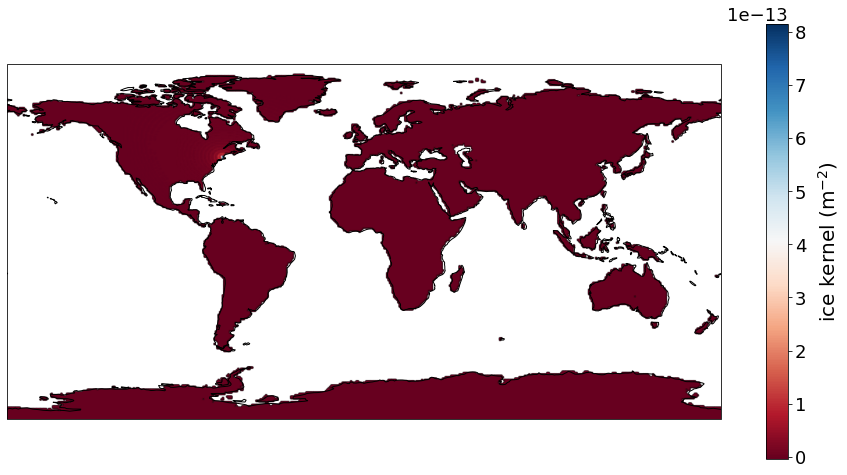

In [5]:
# define and plot the sensitivity kernel with respect to ice thickness
K = SL.rhoi*(1-C)*sl_d
land_mask = SL.land_mask(sl0,ice0)
SL.plot(land_mask*K,label = r'ice kernel (m$^{-2}$)')

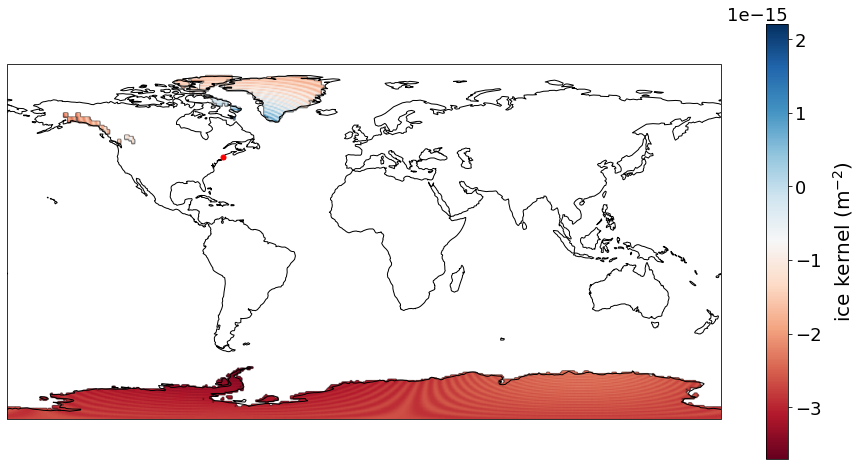

In [6]:
# re-define the kernel such that it is non-zero only where there is grounded ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-2}$)',marker = [lat,lon])

iteration =  1 relative change =  0.013156455848417114
iteration =  2 relative change =  0.0005963356774333958
iteration =  3 relative change =  7.416530933911268e-05
iteration =  4 relative change =  1.4484835246314533e-05
iteration =  5 relative change =  3.1554593040785355e-06
iteration =  6 relative change =  7.406044139628621e-07
iteration =  7 relative change =  1.8630939252106086e-07
iteration =  8 relative change =  4.997681523057477e-08
iteration =  9 relative change =  1.4295162138337077e-08
iteration =  10 relative change =  4.3696084481859024e-09


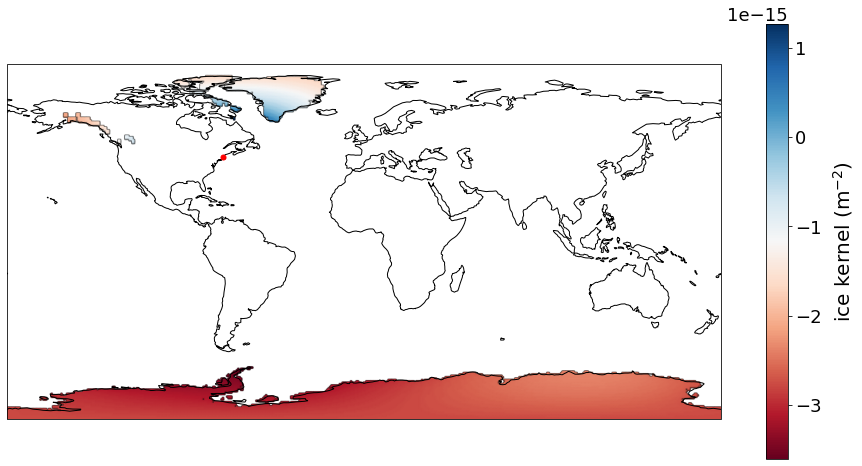

In [7]:
# compute the adjoint load for a SMOOTHED point load
zeta_d,_,_,_ = SL.sea_level_load(L,lat,lon,angle = 1.)

# solve the sea level equation for SL^{\dagger} and plot
sl_d,_,_,_,_ = SL.fingerprint(C,zeta_d)

# set and plot the kernel projected onto regions of grounded ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-2}$)',marker = [lat,lon])


## Sensitivity kernel for vertical displacement measurement



iteration =  1 relative change =  0.004824475782954492
iteration =  2 relative change =  7.940893327069527e-05
iteration =  3 relative change =  1.853709498500912e-05
iteration =  4 relative change =  4.620737370125089e-06
iteration =  5 relative change =  1.1903292178925818e-06
iteration =  6 relative change =  3.172157435743543e-07
iteration =  7 relative change =  8.744286176764194e-08
iteration =  8 relative change =  2.4887620537133234e-08
iteration =  9 relative change =  7.290933535606349e-09

direct displacement value =  -0.00033238505163065286
left hand side            =  -0.0003323850935343668
right hand side           =  -0.00033238505163065096
relative difference       =  1.260697806968689e-07

iteration =  1 relative change =  0.008350225518875584
iteration =  2 relative change =  0.00018634732852444724
iteration =  3 relative change =  4.202633733683778e-05
iteration =  4 relative change =  1.0475867658385429e-05
iteration =  5 relative change =  2.6986410412750824e-06
it

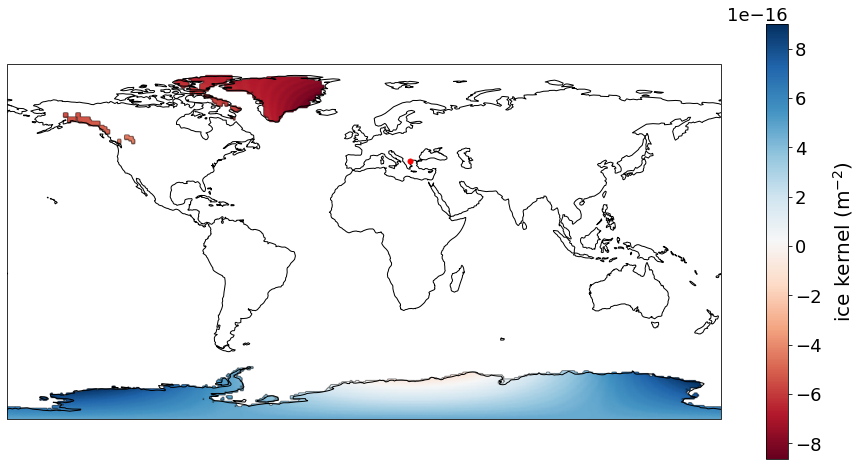

In [8]:
# set the observation point in Thessaloniki
lat = 40.6401
lon = 22.9444
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 0)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the displacement directly
u_lm = u.expand();
u_direct = pysh.expand.MakeGridPoint(u_lm.coeffs,lat,lon+180)

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct displacement value = ',u_direct)
print('left hand side            = ', lhs)
print('right hand side           = ',rhs)
print('relative difference       = ', np.abs((lhs-rhs)/lhs))
print('')


# compute and plot the sensitivity kernel wrt ice thickness, but smoothing the point load
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 1)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-2}$)',marker = [lat,lon])

iteration =  1 relative change =  0.00229547618848338
iteration =  2 relative change =  0.00012758207329033804
iteration =  3 relative change =  1.595015836108793e-05
iteration =  4 relative change =  2.567478471562643e-06
iteration =  5 relative change =  5.105416650603532e-07
iteration =  6 relative change =  1.130737187552754e-07
iteration =  7 relative change =  2.7400224240315968e-08
iteration =  8 relative change =  7.293638865868796e-09

direct displacement value =  0.00018083483176460462
left hand side            =  0.00018083489797899685
right hand side           =  0.00018083483176460557
relative difference       =  3.661593642783354e-07

iteration =  1 relative change =  0.006689186513777677
iteration =  2 relative change =  0.0003160670125120319
iteration =  3 relative change =  3.782821427281749e-05
iteration =  4 relative change =  6.09278274034289e-06
iteration =  5 relative change =  1.1617797755045551e-06
iteration =  6 relative change =  2.562201083140132e-07
iteratio

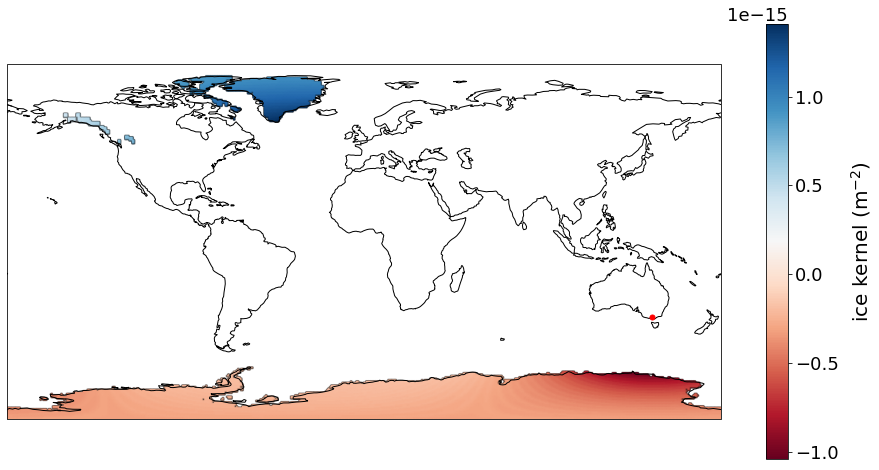

In [9]:
# set the observation point in Melborne
lat = -37.8136
lon = 144.9631
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 0)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the displacement directly
u_lm = u.expand();
u_direct = pysh.expand.MakeGridPoint(u_lm.coeffs,lat,lon+180)

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct displacement value = ',u_direct)
print('left hand side            = ', lhs)
print('right hand side           = ',rhs)
print('relative difference       = ', np.abs((lhs-rhs)/lhs))
print('')


# compute and plot the sensitivity kernel wrt ice thickness, but smoothing the point load
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 1)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-2}$)',marker = [lat,lon])

## Sensitivity kernel for gravitational potential coefficient measurement


iteration =  1 relative change =  0.12119993366418241
iteration =  2 relative change =  0.014913723109157586
iteration =  3 relative change =  0.0019680030013905438
iteration =  4 relative change =  0.0003216644123907741
iteration =  5 relative change =  6.0200465281315164e-05
iteration =  6 relative change =  1.2793662590225956e-05
iteration =  7 relative change =  3.3084147639307243e-06
iteration =  8 relative change =  9.081893268313863e-07
iteration =  9 relative change =  2.5250707764328586e-07
iteration =  10 relative change =  7.192525768695002e-08
iteration =  11 relative change =  2.104530637909058e-08
iteration =  12 relative change =  6.3131384957043e-09

direct potential value    =  -0.0014259474433806513
left hand side            =  -0.0014259473872670052
right hand side           =  -0.001425947443380652
relative difference       =  3.9351835289564974e-08



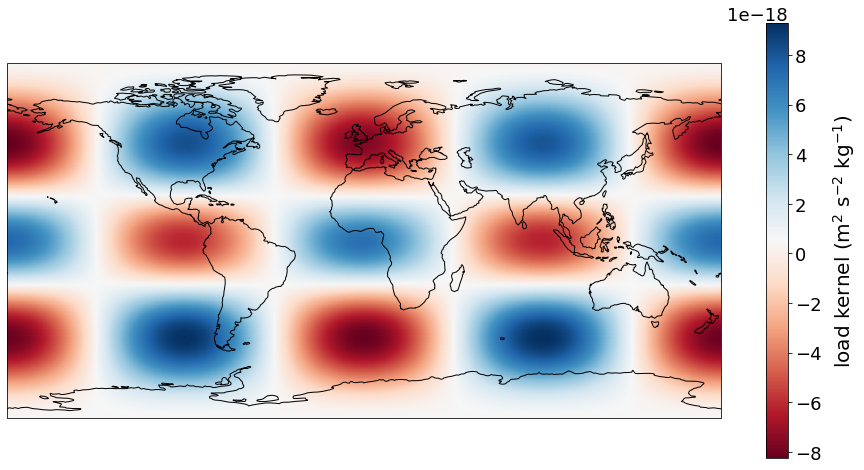

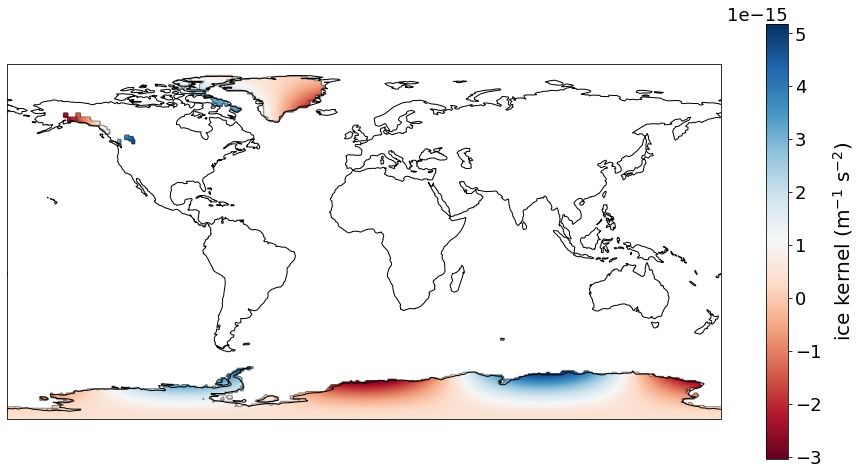

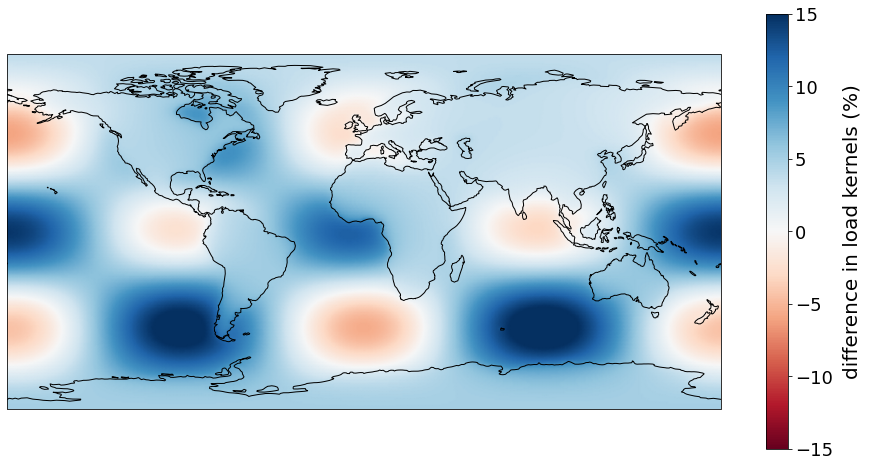

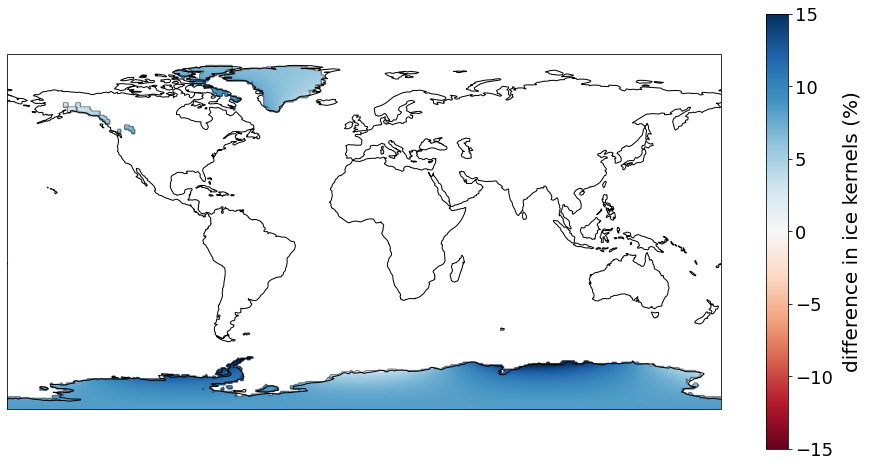

In [10]:
# set the adjoint loads
l = 4
m = 2
zeta_d, zeta_u_d, zeta_phi_d, kk_d = SL.potential_coefficient_load(L,l,m,remove_psi = True)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the potential coefficient directly
phi_lm = phi.expand(normalization='ortho')
if(m >= 0):
    phi_direct = phi_lm.coeffs[0,l,m]
else:
    phi_direct = phi_lm.coeffs[1,l,-m]

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct potential value    = ',phi_direct)
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')


# plot the sensitivity kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m$^{2}$ s$^{-2}$ kg$^{-1}$)')


# plot the sensitivity kernel wrt ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-1}$ s$^{-2}$)')

# get the love numbers
_,k,_,_ = SL.love_numbers(L)

# compute the kernel ignoring water loading
K_d_lm = pysh.SHCoeffs.from_zeros(lmax=L,normalization = 'ortho')
if(m > 0):
    K_d_lm.coeffs[0,l,m] = k[l]/SL.b**2
else:
    K_d_lm.coeffs[1,l,-m] = k[l]/SL.b**2   
K_d = K_d_lm.expand(grid = 'GLQ')


# plot the sensitivity kernel wrt zeta minus direct kernel
norm = np.max(np.abs(sl_d.data))
SL.plot(100*(sl_d-K_d)/norm,label = r'difference in load kernels (%)',clim = [-15,15])


# plot the sensitivity kernel wrt ice
K1 = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
K2 = SL.rhoi*(1-C)*K_d*SL.ice_mask(sl0,ice0,val = 0.)
norm = np.max(np.abs(K1.data))
SL.plot(100*ice_mask*(K1-K2)/norm,label = r'difference in ice kernels (%)',clim = [-15,15])


iteration =  1 relative change =  0.04262949357329468
iteration =  2 relative change =  0.002157817321471703
iteration =  3 relative change =  0.00014939724642844114
iteration =  4 relative change =  1.6262281564288335e-05
iteration =  5 relative change =  2.6839505206953964e-06
iteration =  6 relative change =  5.363033202263536e-07
iteration =  7 relative change =  1.1997763276505245e-07
iteration =  8 relative change =  2.867843834211519e-08
iteration =  9 relative change =  7.24813147582916e-09

direct potential value    =  0.0005198516636610985
left hand side            =  0.0005198516555442941
right hand side           =  0.0005198516636610985
relative difference       =  1.561369352686534e-08



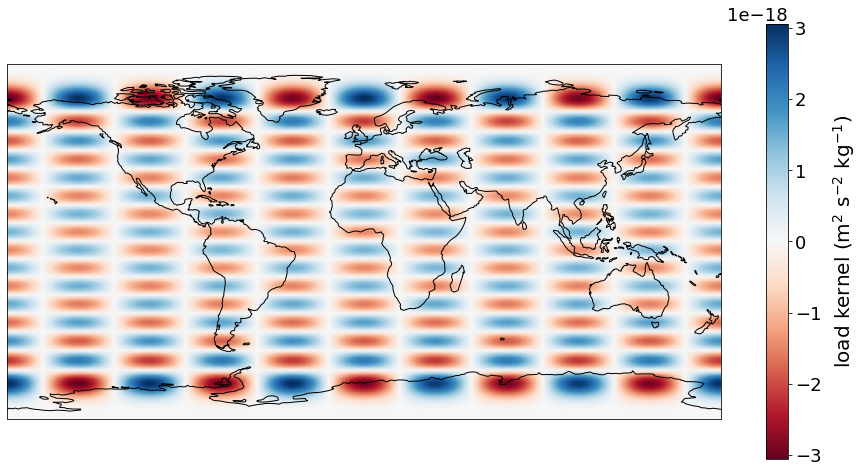

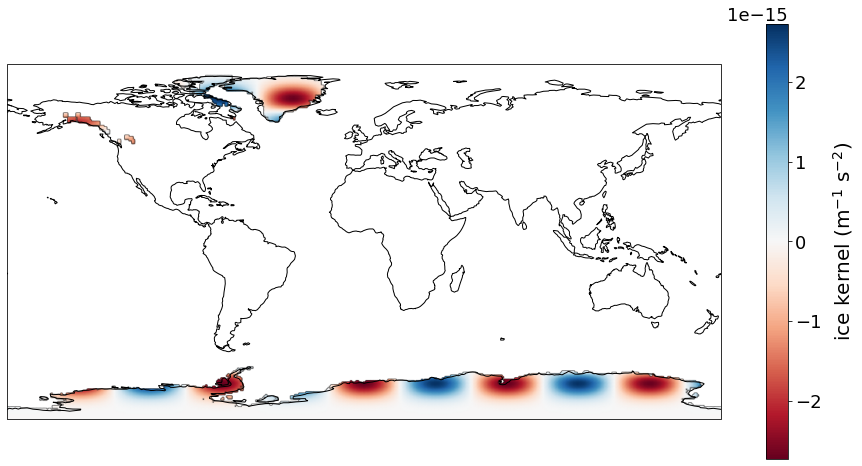

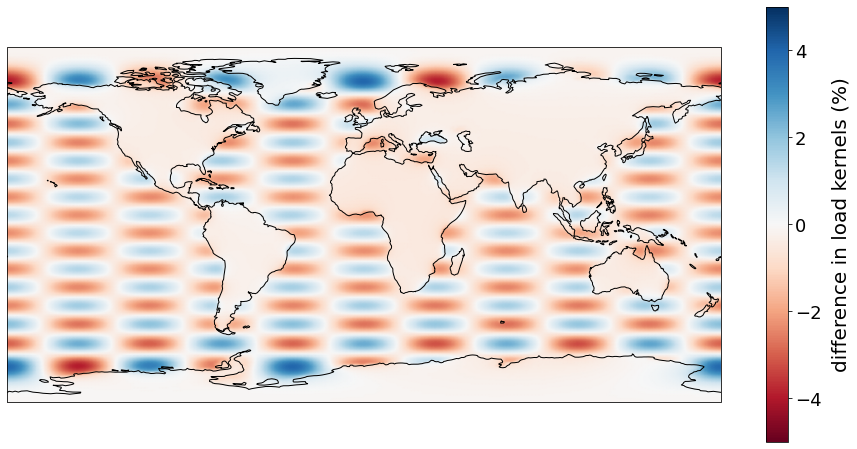

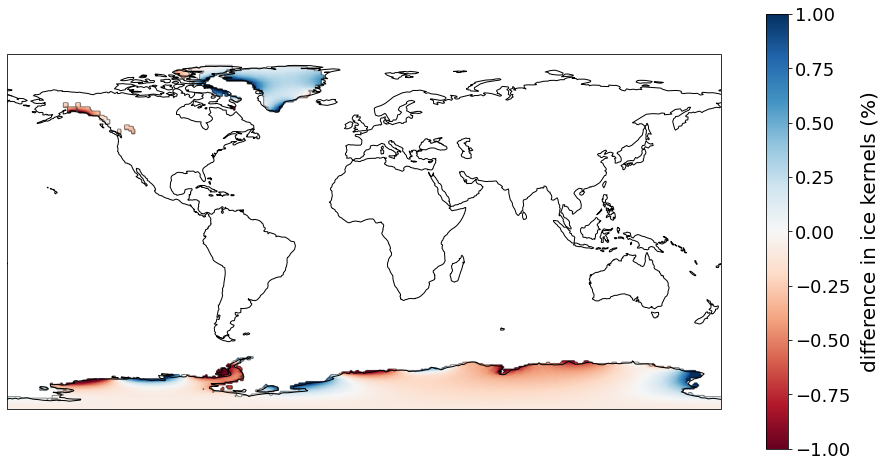

In [11]:
# set the adjoint loads for a higher degree
l = 20
m = 5
zeta_d, zeta_u_d, zeta_phi_d, kk_d = SL.potential_coefficient_load(L,l,m,remove_psi = True)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the potential coefficient directly
phi_lm = phi.expand(normalization='ortho')
if(m >= 0):
    phi_direct = phi_lm.coeffs[0,l,m]
else:
    phi_direct = phi_lm.coeffs[1,l,-m]

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct potential value    = ',phi_direct)
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')


# plot the sensitivity kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m$^{2}$ s$^{-2}$ kg$^{-1}$)')


# plot the sensitivity kernel wrt ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-1}$ s$^{-2}$)')

# get the love numbers
_,k,_,_ = SL.love_numbers(L)

# compute the kernel ignoring water loading
K_d_lm = pysh.SHCoeffs.from_zeros(lmax=L,normalization = 'ortho')
if(m > 0):
    K_d_lm.coeffs[0,l,m] = k[l]/SL.b**2
else:
    K_d_lm.coeffs[1,l,-m] = k[l]/SL.b**2   
K_d = K_d_lm.expand(grid = 'GLQ')


# plot the sensitivity kernel wrt zeta minus direct kernel
norm = np.max(np.abs(sl_d.data))
SL.plot(100*(sl_d-K_d)/norm,label = r'difference in load kernels (%)',clim = [-5,5])


# plot the sensitivity kernel wrt ice
K1 = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
K2 = SL.rhoi*(1-C)*K_d*SL.ice_mask(sl0,ice0,val = 0.)
norm = np.max(np.abs(K1.data))
SL.plot(100*ice_mask*(K1-K2)/norm,label = r'difference in ice kernels (%)',clim = [-1,1])


## Sensitivity kernels for Grace load averages

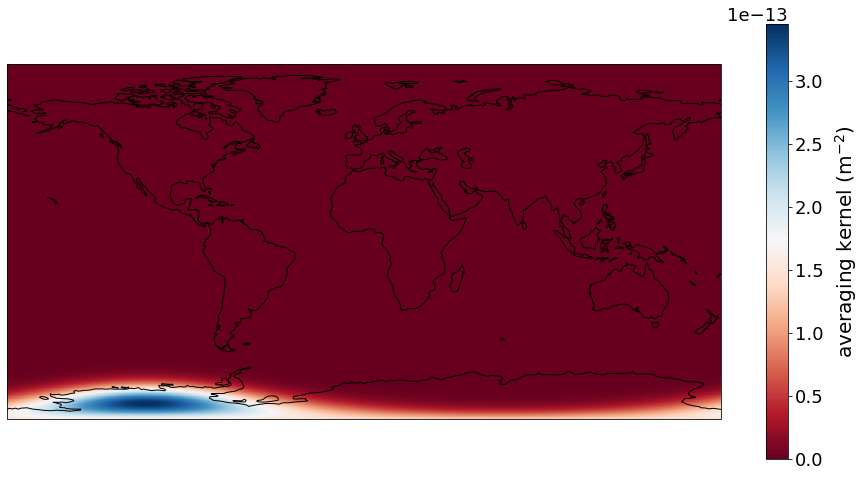

iteration =  1 relative change =  0.019287233867069487
iteration =  2 relative change =  0.0008353965061317644
iteration =  3 relative change =  8.909354189540987e-05
iteration =  4 relative change =  1.8275397019042283e-05
iteration =  5 relative change =  4.001041369943763e-06
iteration =  6 relative change =  9.405987127881529e-07
iteration =  7 relative change =  2.3756401142990745e-07
iteration =  8 relative change =  6.407008177473957e-08
iteration =  9 relative change =  1.8235452067874645e-08
iteration =  10 relative change =  5.406298237140309e-09

left hand side            =  -63.771543219715994
right hand side           =  -63.77154971348905
relative difference       =  1.0182869551526647e-07



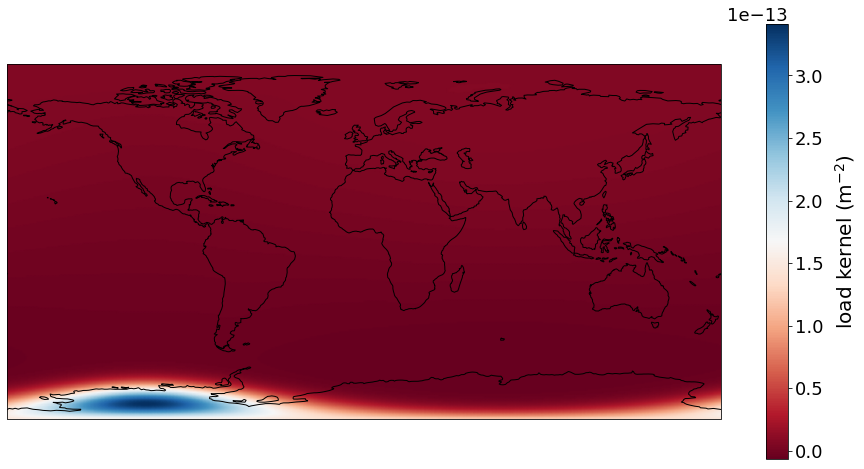

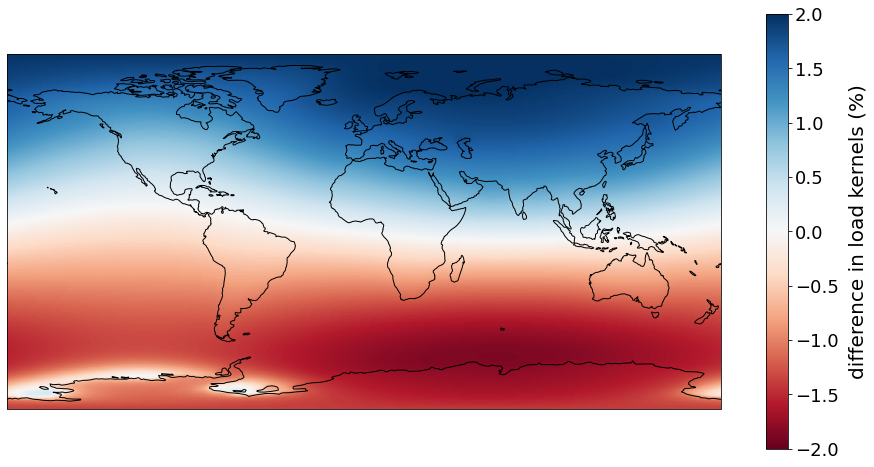

GRACE average of load =  -0.06377154971348903
average of direct load  =  -0.06921364787783699
relative difference with direct load average   =  -7.862752984719624 %


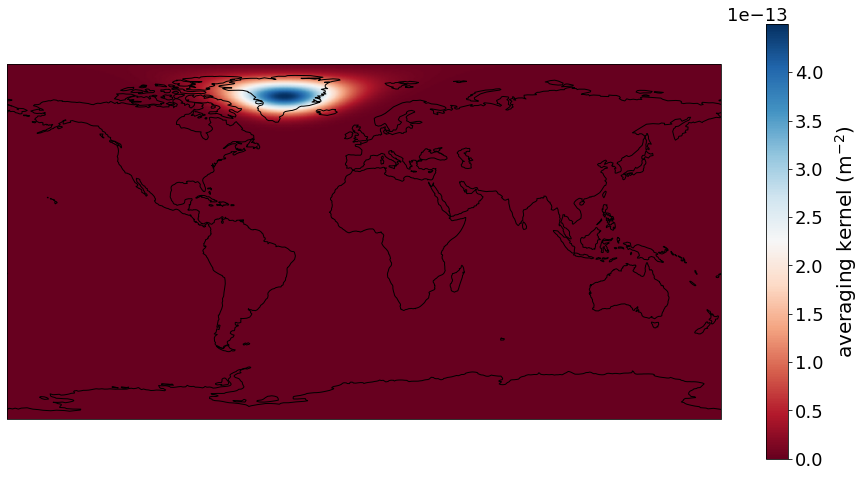

iteration =  1 relative change =  0.021487581505322692
iteration =  2 relative change =  0.0012576608952577508
iteration =  3 relative change =  0.0001512431876419979
iteration =  4 relative change =  3.613435643981675e-05
iteration =  5 relative change =  8.981734218228805e-06
iteration =  6 relative change =  2.332672458809012e-06
iteration =  7 relative change =  6.333221567120639e-07
iteration =  8 relative change =  1.7914095922904484e-07
iteration =  9 relative change =  5.249764968744453e-08
iteration =  10 relative change =  1.5825736219071858e-08
iteration =  11 relative change =  4.874496026473986e-09

left hand side            =  -116.39338722470048
right hand side           =  -116.39339011755952
relative difference       =  2.4854152910623837e-08



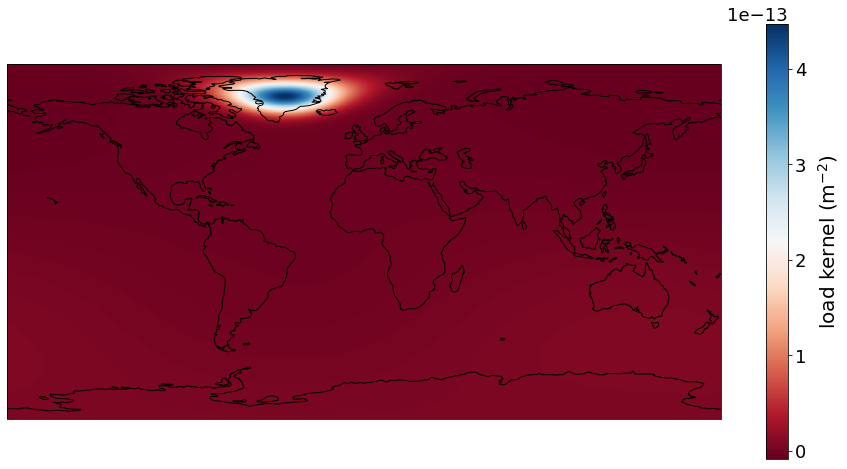

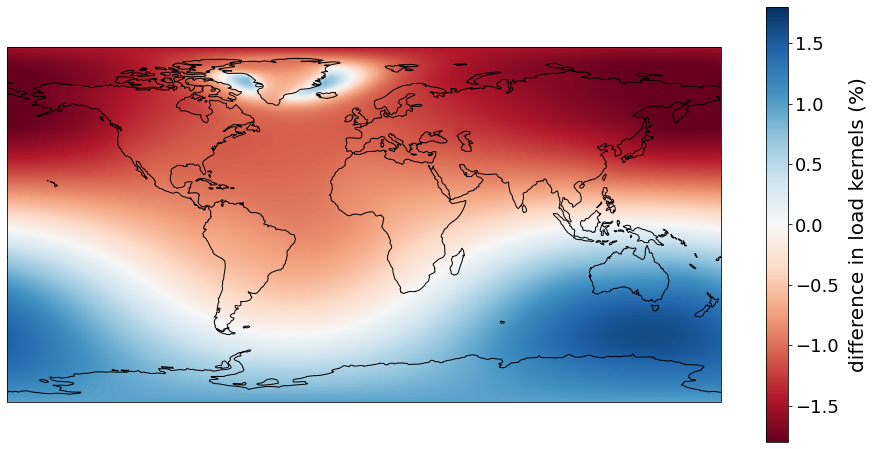

GRACE average of load =  -0.11639339011755935
average of direct load  =  -0.1107249212179943
relative difference with direct load average   =  5.119415608709284 %


In [12]:
# cut out degrees 0 and 1 from averaging function?
cut = False

# truncation degree for GRACE average (LT = 0 means no truncation)
LT = 100


# define the averaging function as in Wahr et al. (1998) targeted at W. Antarctic
w = SL.gaussian_averaging_function(L,r = 800,lat0 = -82.,lon0 = -110.,cut = cut)
SL.plot(w,label = r'averaging kernel (m$^{-2}$)')


# form the adjoint loads
zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.GRACE_average_load(w,LT = LT)

# solve the adjoint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# check the kernel is working okay
lhs = SL.surface_integral(sl_d*zeta)
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g
print('')
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')

# plot the kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m$^{-2}$)')

GRACE_average = SL.GRACE_average_measurement(phi,w,LT = LT)/SL.rhow
direct_load_average = SL.surface_integral(zeta*w)/SL.rhow

# plot the kernel wrt zeta
norm = np.max(np.abs(w.data[:,:]))
SL.plot(100*(sl_d-w)/norm,label = 'difference in load kernels (%)',clim = [-2,2])

print('GRACE average of load = ',GRACE_average)
print('average of direct load  = ',direct_load_average)
print('relative difference with direct load average   = ',100*(GRACE_average-direct_load_average) \
                                                               /direct_load_average,'%')


##########################################################
# now do the same thing but for a Greenland average

# define the averaging function as in Wahr et al. (1998) targeted at W. Antarctic
w = SL.gaussian_averaging_function(L,r = 700,lat0 = 73.,lon0 = -40.,cut = cut)
SL.plot(w,label = r'averaging kernel (m$^{-2}$)')

# form the adjoint loads
zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.GRACE_average_load(w,LT = LT)

# solve the adjoint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# check the kernel is working okay
lhs = SL.surface_integral(sl_d*zeta)
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g
print('')
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')

# plot the kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m$^{-2}$)')

GRACE_average      = SL.GRACE_average_measurement(phi,w,LT = LT)/SL.rhow
direct_load_average = SL.surface_integral(zeta*w)/SL.rhow


# plot the kernel wrt zeta
norm = np.max(np.abs(w.data[:,:]))
SL.plot(100*(sl_d-w)/norm,label = 'difference in load kernels (%)',clim = [-1.8,1.8])

print('GRACE average of load = ',GRACE_average)
print('average of direct load  = ',direct_load_average)
print('relative difference with direct load average   = ',100*(GRACE_average-direct_load_average) \
                                                               /direct_load_average,'%')






## Case 4: Sensitivity kernels for sea surface height

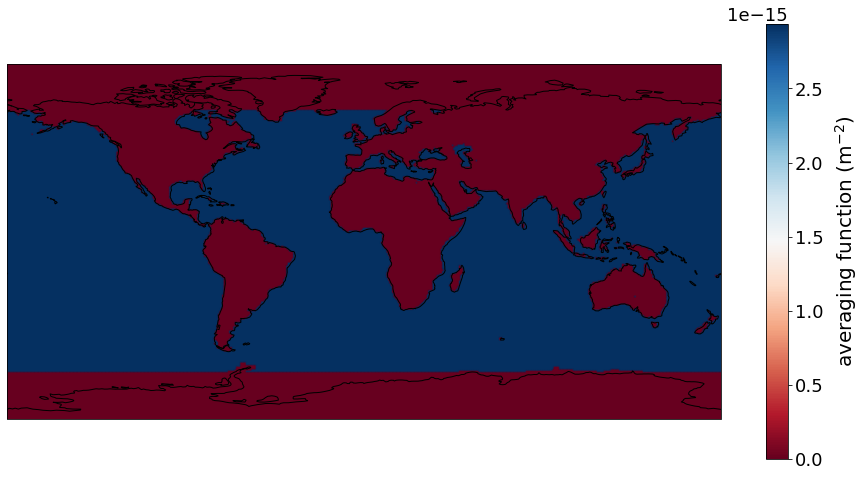

iteration =  1 relative change =  0.009460581914690706
iteration =  2 relative change =  0.0017869440576190152
iteration =  3 relative change =  0.00039579066299708153
iteration =  4 relative change =  8.844629502541011e-05
iteration =  5 relative change =  1.9967669559718464e-05
iteration =  6 relative change =  4.561268215544367e-06
iteration =  7 relative change =  1.0561130389653484e-06
iteration =  8 relative change =  2.4840194456419614e-07
iteration =  9 relative change =  5.9544389442584795e-08
iteration =  10 relative change =  1.4596641186475248e-08
iteration =  11 relative change =  3.673169248098547e-09

direct ssh value     =  0.004900595433730101
left hand side       =  0.004900595390000586
right hand side      =  0.004900595433730101
relative difference  =  8.923306521110538e-09



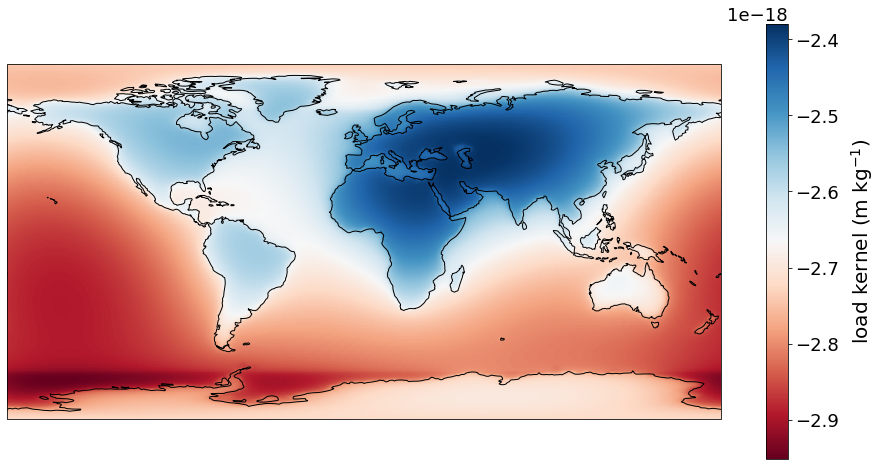

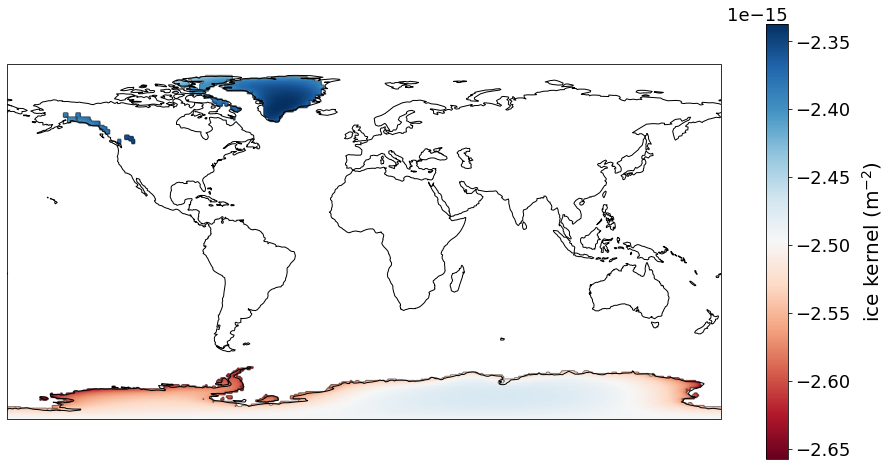

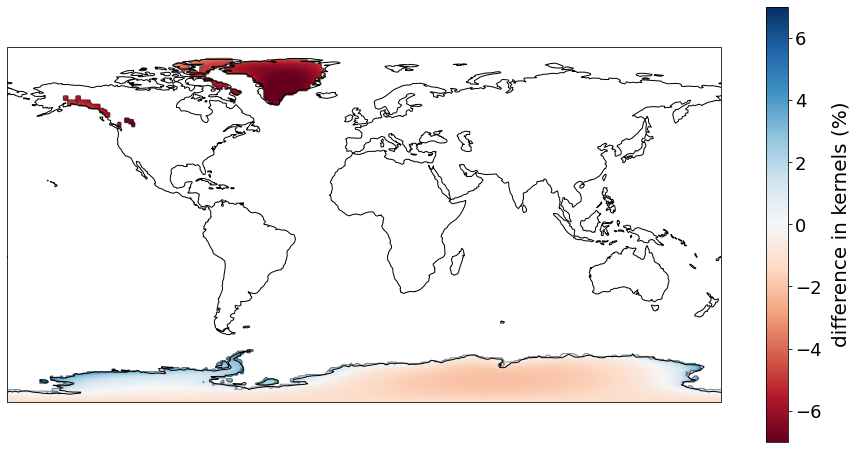

percentage difference from GMSL =  -1.9880913253979802 %

iteration =  1 relative change =  0.02083971663802765
iteration =  2 relative change =  0.002518332108500906
iteration =  3 relative change =  0.00042193585434859834
iteration =  4 relative change =  8.329667613317142e-05
iteration =  5 relative change =  1.812486543246729e-05
iteration =  6 relative change =  4.253103521387658e-06
iteration =  7 relative change =  1.0710258354711034e-06
iteration =  8 relative change =  2.878827120401929e-07
iteration =  9 relative change =  8.224743742746535e-08
iteration =  10 relative change =  2.5151295830140936e-08
iteration =  11 relative change =  7.83562160907846e-09

percentage difference from GMSL =  -6.741805285895799 %


In [15]:
# set the adjoint loads
zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.sea_altimetery_load(sl0,ice0,taper = False)

SL.plot(zeta_d,label = r'averaging function (m$^{-2}$)')

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# form the sea surface height directly
ssh = sl + u + psi/SL.g

# set the observational area and form the average
ssh_direct = SL.surface_integral(ssh*zeta_d)

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct ssh value     = ',ssh_direct)
print('left hand side       = ',lhs)
print('right hand side      = ',rhs)
print('relative difference  = ',np.abs((lhs-rhs)/lhs))
print('')


# plot the kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m kg$^{-1}$)')

# plot the kernel wrt I
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-2}$)')

Kval = -SL.rhoi/(SL.rhow*A)
Ki = Kval*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(100*ice_mask*(K-Ki)/Kval,label = r'difference in kernels (%)',clim = [-7,7])

# determine the difference between the altimetery estimate the GMSL
print('percentage difference from GMSL = ',100*(ssh_direct-GMSL)/np.abs(GMSL),"%")
print('')



#######################################################################
# do the same again, but now consider a northern hemisphere only source

zeta_2 = GMSL*zeta_north
sl_2,u_2,phi_2,om_2,psi_2 = SL.fingerprint(C,zeta_2)
ssh_2 = sl_2 + u_2 + psi_2/SL.g
ssh_direct = SL.surface_integral(ssh_2*zeta_d)
print('')
print('percentage difference from GMSL = ',100*(ssh_direct-GMSL)/np.abs(GMSL),"%")
